# Machine Learning Project - Credit Card Fraud Detection
# Introduction
It is imperative that credit card companies possess the capability to accurately identify fraudulent credit card transactions, thereby ensuring that customers are not subjected to charges for products they have not procured. The present study aims to develop a machine learning model that utilises this data set to predict fraudulent transactions with a high degree of accuracy.


1. [Load and Check Data](#1)
2. [Variable Description](#2)
3. [Visualization](#3)
    * [Correlation Between Features](#4)
    * [Distribution Analysis](#5)
    * [Time-Based Analysis](#6)
    * [Transactions Amaunt](#7)
4. [Processing Data](#8)
    * [Scaling](#9)
    * [Splitting Data](#10)
5. [Predictive Models](#11)
    * [RandomForestClassifier](#12)
    * [AdaBoostClassifier](#13)
    * [CatBoostClassifier](#14)
    * [XGBoost](#15)
    * [LightGBM](#16)
6. [Conclusion](#17)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from lightgbm.callback import log_evaluation
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

from collections import Counter 

RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


<a id = "1"></a><br>
# Load and Check Data

In [2]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.369007e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.500885e-15,-5.620335e-16,1.149614e-16,-2.426963e-15,...,1.596686e-16,-3.576577e-16,2.650499e-16,4.472317e-15,5.109395e-16,1.686100e-15,-3.662399e-16,-1.225457e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<a id = "2"></a><br>
# Variable Description

1. Time: Time elapsed since the first operation (in seconds)
2. Amount: Transaction amount (currency not specified)
3. V1-V28: PCA transformed features
4. Class: 0 = Normal, 1 = Fraud

PCA (Principal Component Analysis) is a technique for reducing the dimensionality of data while preserving important patterns. It transforms correlated variables into a smaller set of uncorrelated components. This helps in removing noise, improving efficiency, and visualizing high-dimensional data.

# Missing Value

In [8]:
#columns have missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

There is no missing value.

<a id = "3"></a><br>
# Visualization

<a id = "4"></a><br>
## Correlation Between Features

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(20, 14))
sns.heatmap(df[numeric_cols].corr(), annot = True, fmt = ".2f")
plt.title('Correlation Between Features')
plt.xticks(rotation= 50, ha = 'right')
plt.show()

Some features show specific correlations with Time (an inverse correlation with V3) and Amount (a direct correlation with V7 and V20, and an inverse correlation with V1 and V5).

Let’s plot both the positively and negatively correlated values on the same graph.

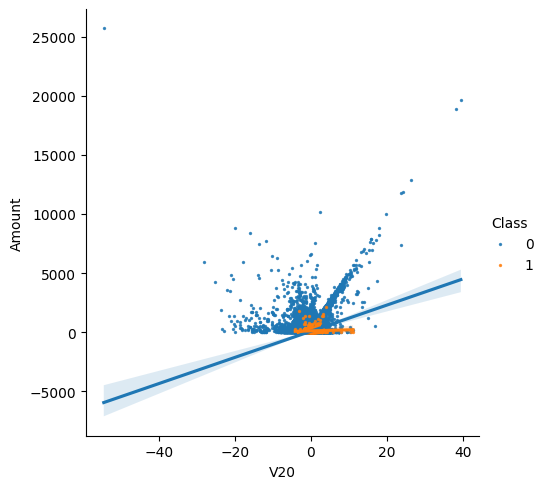

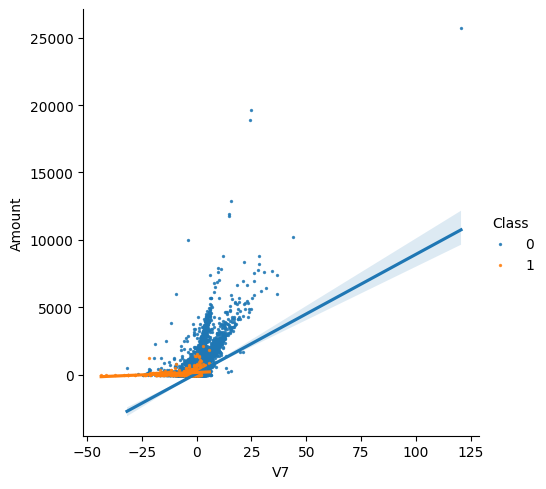

In [10]:
# Amount-V20 Amount-V7
s = sns.lmplot(x='V20', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

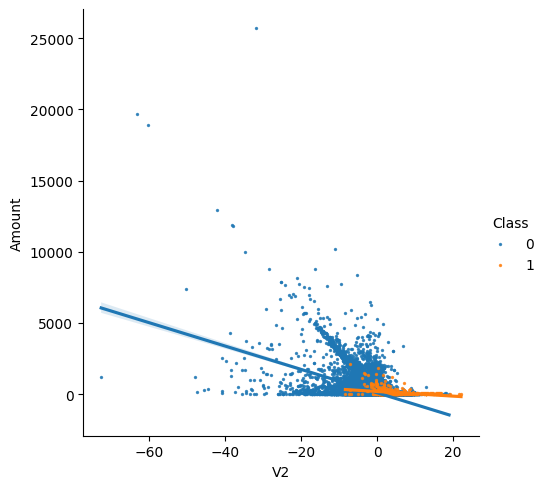

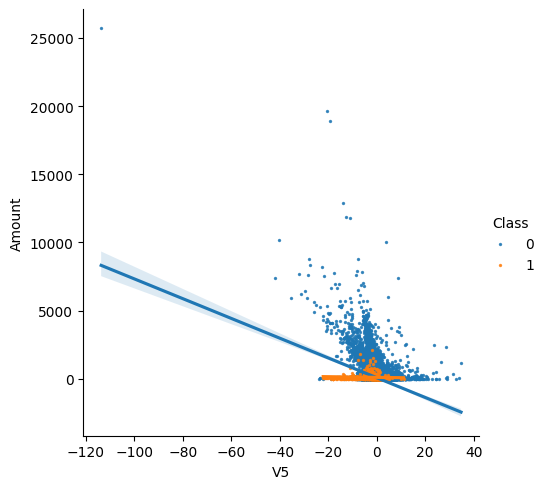

In [11]:
# Amount-V2 Amount-V5
s = sns.lmplot(x='V2', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2}) 
s = sns.lmplot(x='V5', y='Amount',data=df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

<a id = "5"></a><br>
## Distribution Analysis

### Data Unbalance

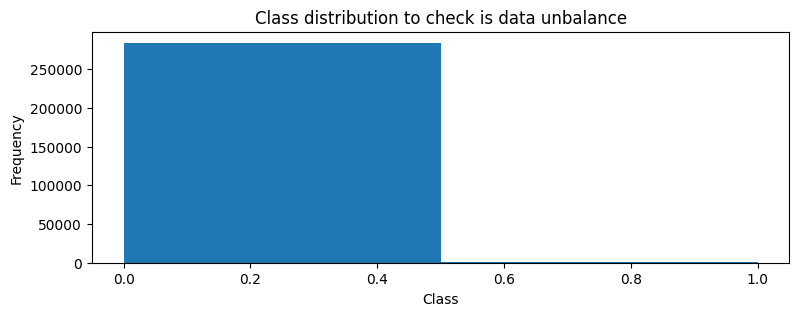

In [12]:
plt.figure(figsize = (9,3))
plt.hist(df['Class'], bins = 2)
plt.xlabel('Class')
plt.ylabel("Frequency")
plt.title("Class distribution to check is data unbalance")
plt.show()

In [13]:
print ("Fraud")
print (df.Time[df.Class == 1].describe(), "\n")
print ("Normal")
print (df.Time[df.Class == 0].describe())
# print ("\nFraud",
#       "\n", df.Time[df.Class == 1].describe(),
#       "\nNormal",
#       "\n", df.Time[df.Class == 0].describe())

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64 

Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


A few of transactions are fraud. That means data is unbalanced.

### Histogram Plots Excluding Class

In [ ]:
Vars = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

plt.figure(figsize=(20, 15))
for i, var in enumerate(Vars):
    plt.subplot(len(Vars)//4 + 1, 4, i+1)
    plt.hist(df[var], bins=20)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title(f"{var} distribution with hist")
plt.tight_layout()
plt.show()

### Histogram Plots Excluding Class (when Class = 1)

In [ ]:
filtered_df = df[df['Class'] == 1]

plt.figure(figsize=(20, 15))
for i, var in enumerate(Vars):
    plt.subplot(len(Vars)//4 + 1, 4, i+1)
    plt.hist(filtered_df[var], bins=20)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.title(f"{var} distribution with hist")
plt.tight_layout()
plt.show()

Let's draw a KDE plot to compare these graphs more easily.

In [ ]:
var = df.columns.values

i = 0
t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

* According to the plots above, normal transactions seem to be concentrated around 0.
* Some features are easily selective like V4, V11 and some features are selective V12, V14, V18.

<a id = "6"></a><br>
## Time-Based Analysis

In [ ]:
df['Time'].dtype

dtype('float64')

In [ ]:
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

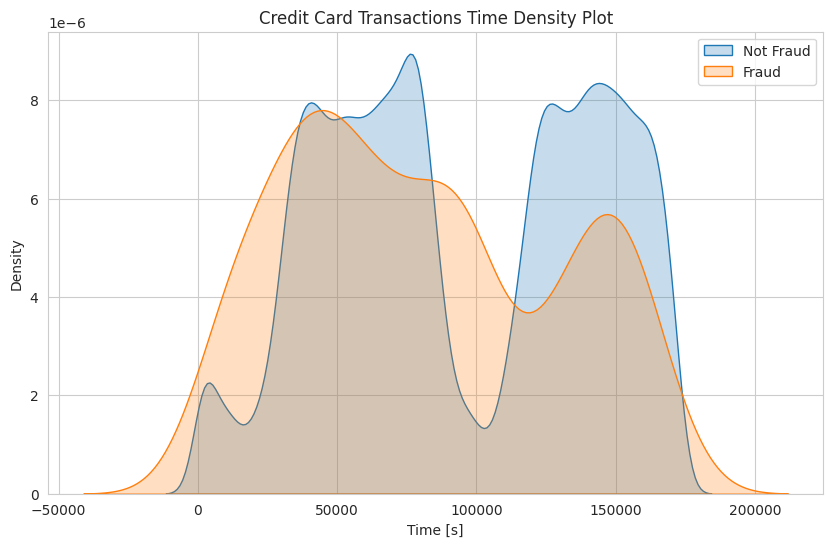

In [19]:
plt.figure(figsize=(10, 6))
sns.kdeplot(class_0, label='Not Fraud', shade=True)
sns.kdeplot(class_1, label='Fraud', shade=True)

plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

In [20]:
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


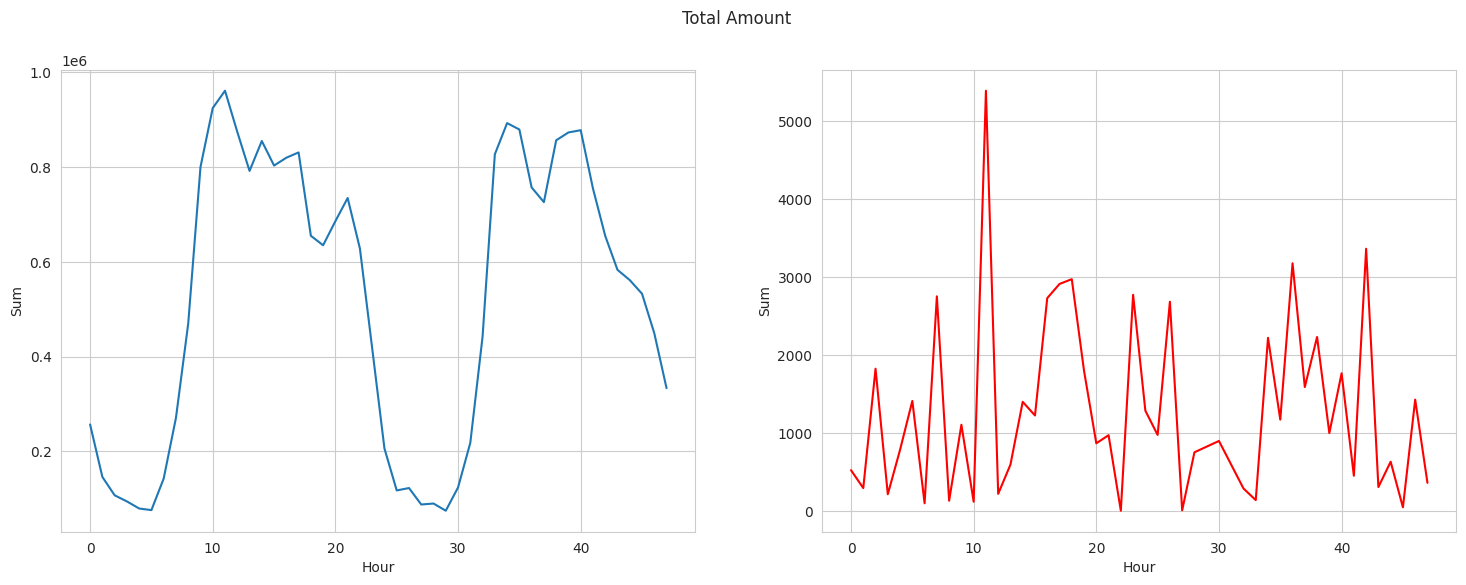

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show()

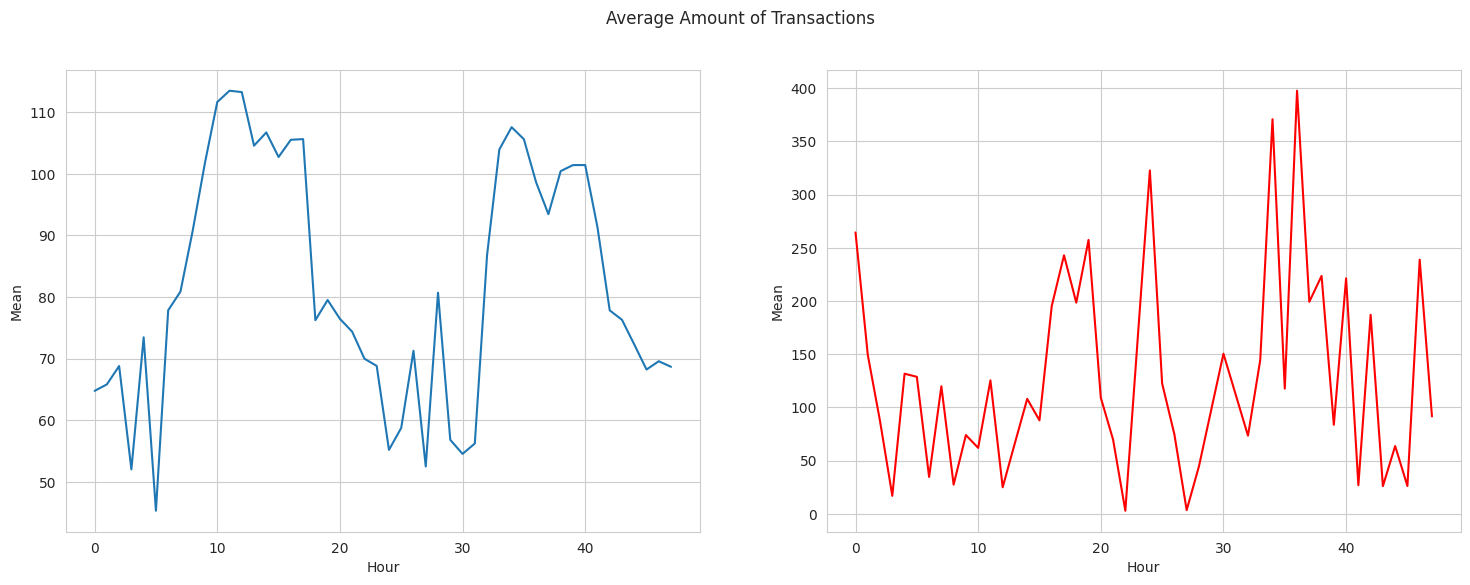

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show()

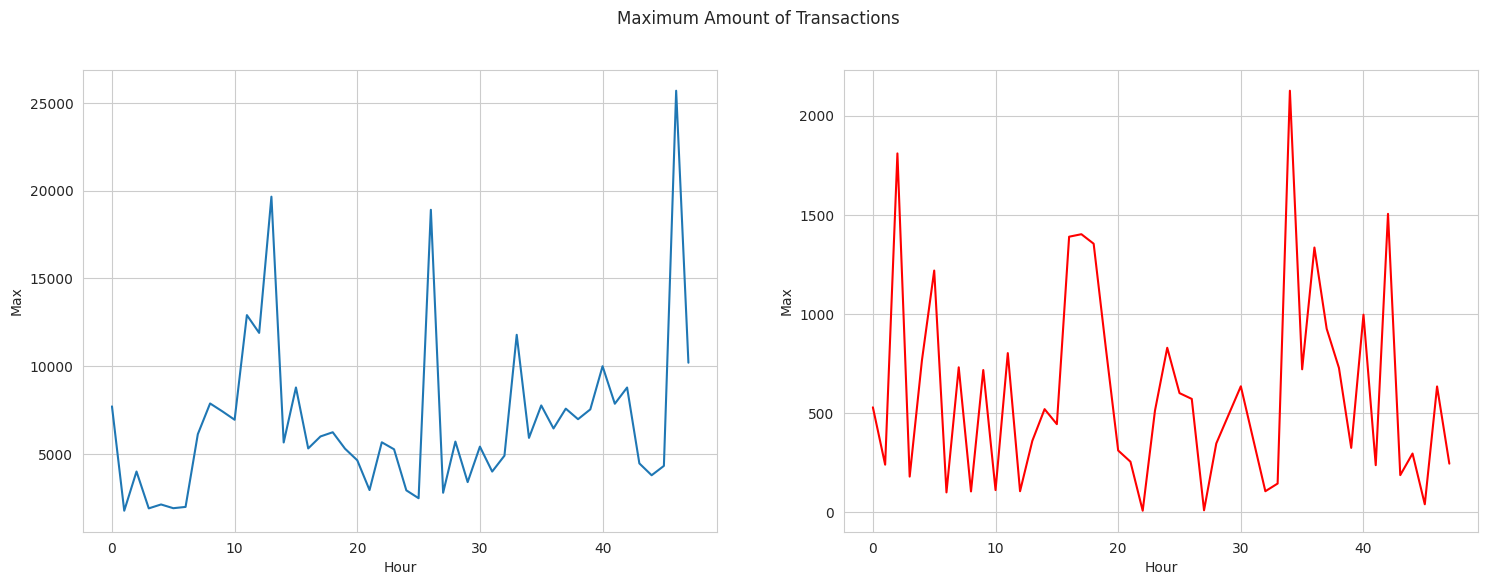

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show()

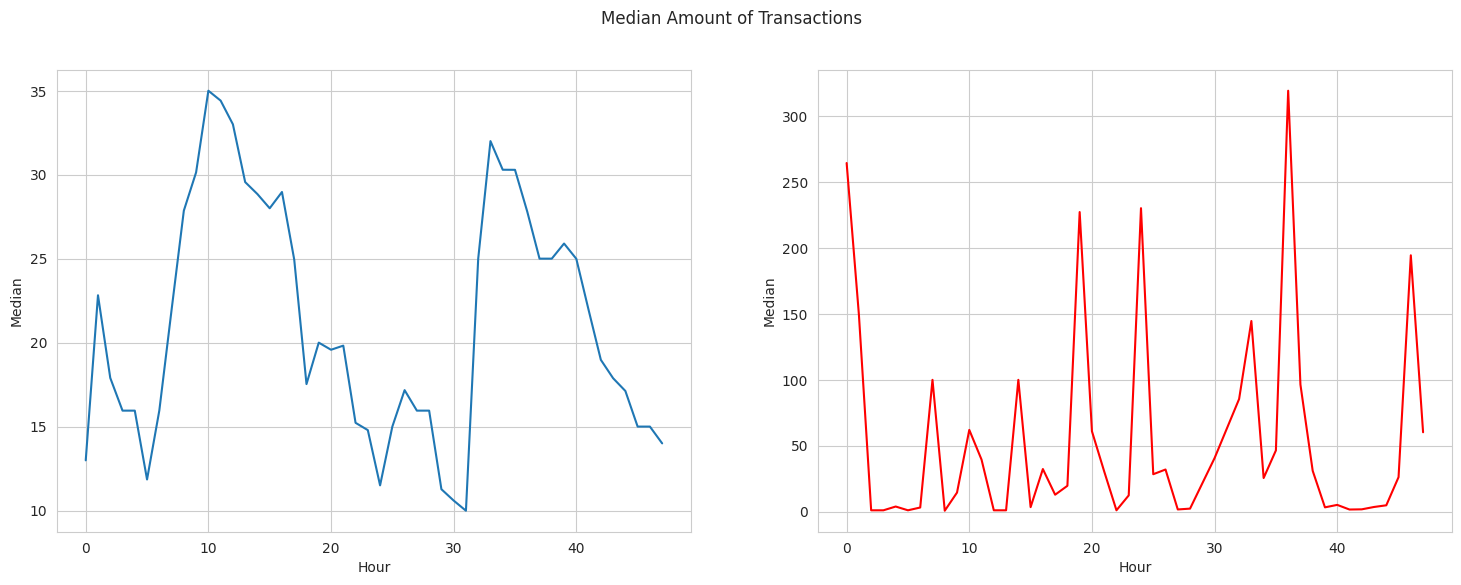

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

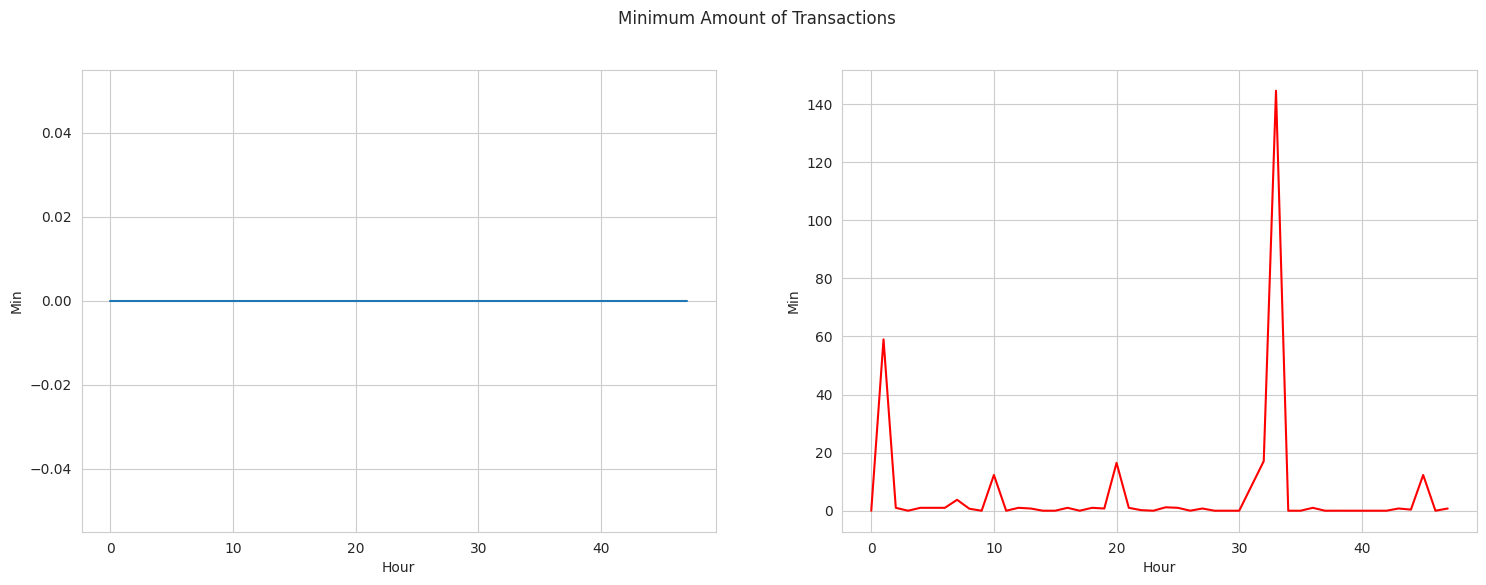

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show()

<a id = "7"></a><br>
## Transactions amount

In [26]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

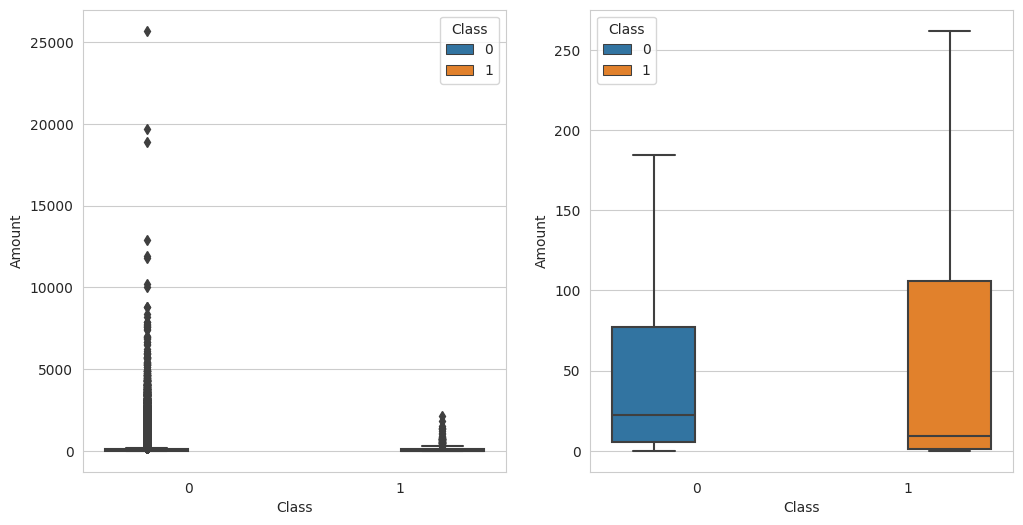

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=df,showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=df,showfliers=False)
plt.show();

Let's see the amount differentations between fraud and normal.

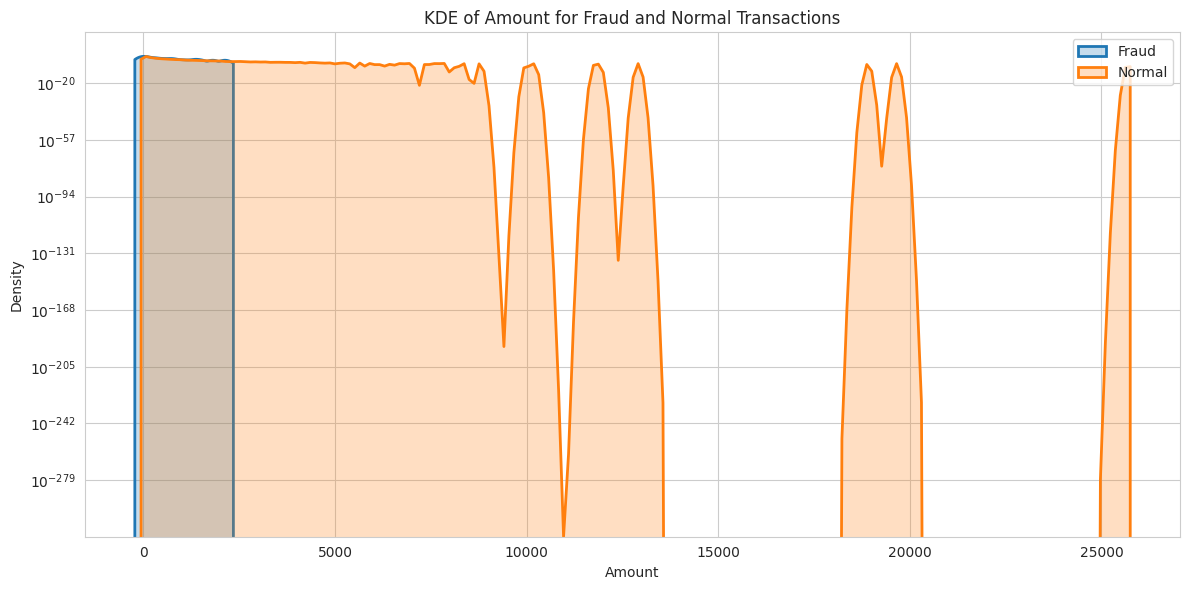

In [28]:
# Görselleştirme
plt.figure(figsize=(12, 6))

# Fraud verisi için KDE (kırmızı renk)
sns.kdeplot(df.Amount[df.Class == 1], fill=True, linewidth=2, label='Fraud')

# Normal verisi için KDE (mavi renk)
sns.kdeplot(df.Amount[df.Class == 0], fill=True, linewidth=2, label='Normal')

# Başlık ve etiketler
plt.title('KDE of Amount for Fraud and Normal Transactions')
plt.xlabel('Amount')
plt.ylabel('Density')

# Logaritmik Y ekseni
plt.yscale('log')

# Efsane (legend)
plt.legend()

plt.tight_layout()
plt.show()

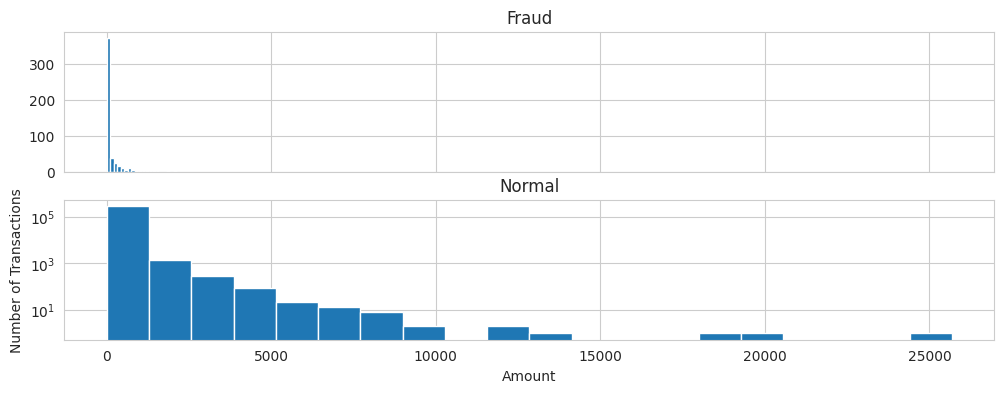

In [29]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(df.Amount[df.Class == 1], bins = 20)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = 20)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log') # Since the data values have a wide range, we can see a better plot when viewed logarithmically
plt.show()

<a id = "9"></a><br>
# Prepocessing Data

## Scaling

In [30]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler() # RobustScaler is less prone to outliers

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)


In [31]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [32]:
# Adjusting the position of columns
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<a id = "10"></a><br>
## Splitting Data

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold


print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values
    
    # See if both the train and test label distribution are similarly distributed
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    print('-' * 100)
    
    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827514 0.00172486]
[0.998262 0.001738]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827514 0.00172486]
[0.998262 0.001738]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]


In [34]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
171212,0.993502,0.421199,1.702664,-0.895510,0.409037,1.780092,-1.318302,0.296116,-1.041867,0.315066,...,-0.214614,-0.005372,0.162414,0.176770,-0.066553,-0.315429,-0.675191,0.081932,-0.010129,0
105178,-0.293440,-0.179725,1.140431,1.134243,-1.429455,2.012226,0.622800,-1.152923,0.221159,0.037372,...,-0.099712,-0.367136,-0.891627,-0.160578,-0.108326,0.668374,-0.352393,0.071993,0.113684,1
32821,2.207643,-0.560545,-0.722121,0.655166,1.415336,0.383292,0.118910,-0.041463,1.625110,-0.592798,...,0.398895,-0.292056,-0.303444,0.041801,0.077404,-0.483697,0.113047,-0.001636,-0.277703,0
251881,-0.263537,0.832364,1.868226,1.363077,-1.994934,4.173516,1.239751,-0.746186,0.572731,-0.131235,...,-0.172216,-0.301001,-0.818972,0.206812,-0.263683,-0.114958,-0.240672,-0.006629,0.017258,1
9252,-0.293440,-0.838461,-5.454362,8.287421,-12.752811,8.594342,-3.106002,-3.179949,-9.252794,4.245062,...,1.305862,1.846165,-0.267172,-0.310804,-1.201685,1.352176,0.608425,1.574715,0.808725,1


In [35]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 171212 to 55401
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   scaled_amount  984 non-null    float64
 1   scaled_time    984 non-null    float64
 2   V1             984 non-null    float64
 3   V2             984 non-null    float64
 4   V3             984 non-null    float64
 5   V4             984 non-null    float64
 6   V5             984 non-null    float64
 7   V6             984 non-null    float64
 8   V7             984 non-null    float64
 9   V8             984 non-null    float64
 10  V9             984 non-null    float64
 11  V10            984 non-null    float64
 12  V11            984 non-null    float64
 13  V12            984 non-null    float64
 14  V13            984 non-null    float64
 15  V14            984 non-null    float64
 16  V15            984 non-null    float64
 17  V16            984 non-null    float64
 18  V17     

Distribution of the Classes in the subsample dataset
Class
0    0.5
1    0.5
Name: count, dtype: float64


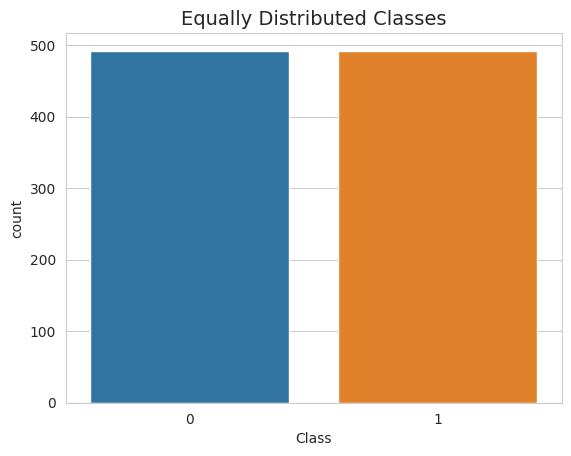

In [36]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot(x='Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


In this data, the number of fraud and normal data is the same because as many normal data were selected as the number of fraud data

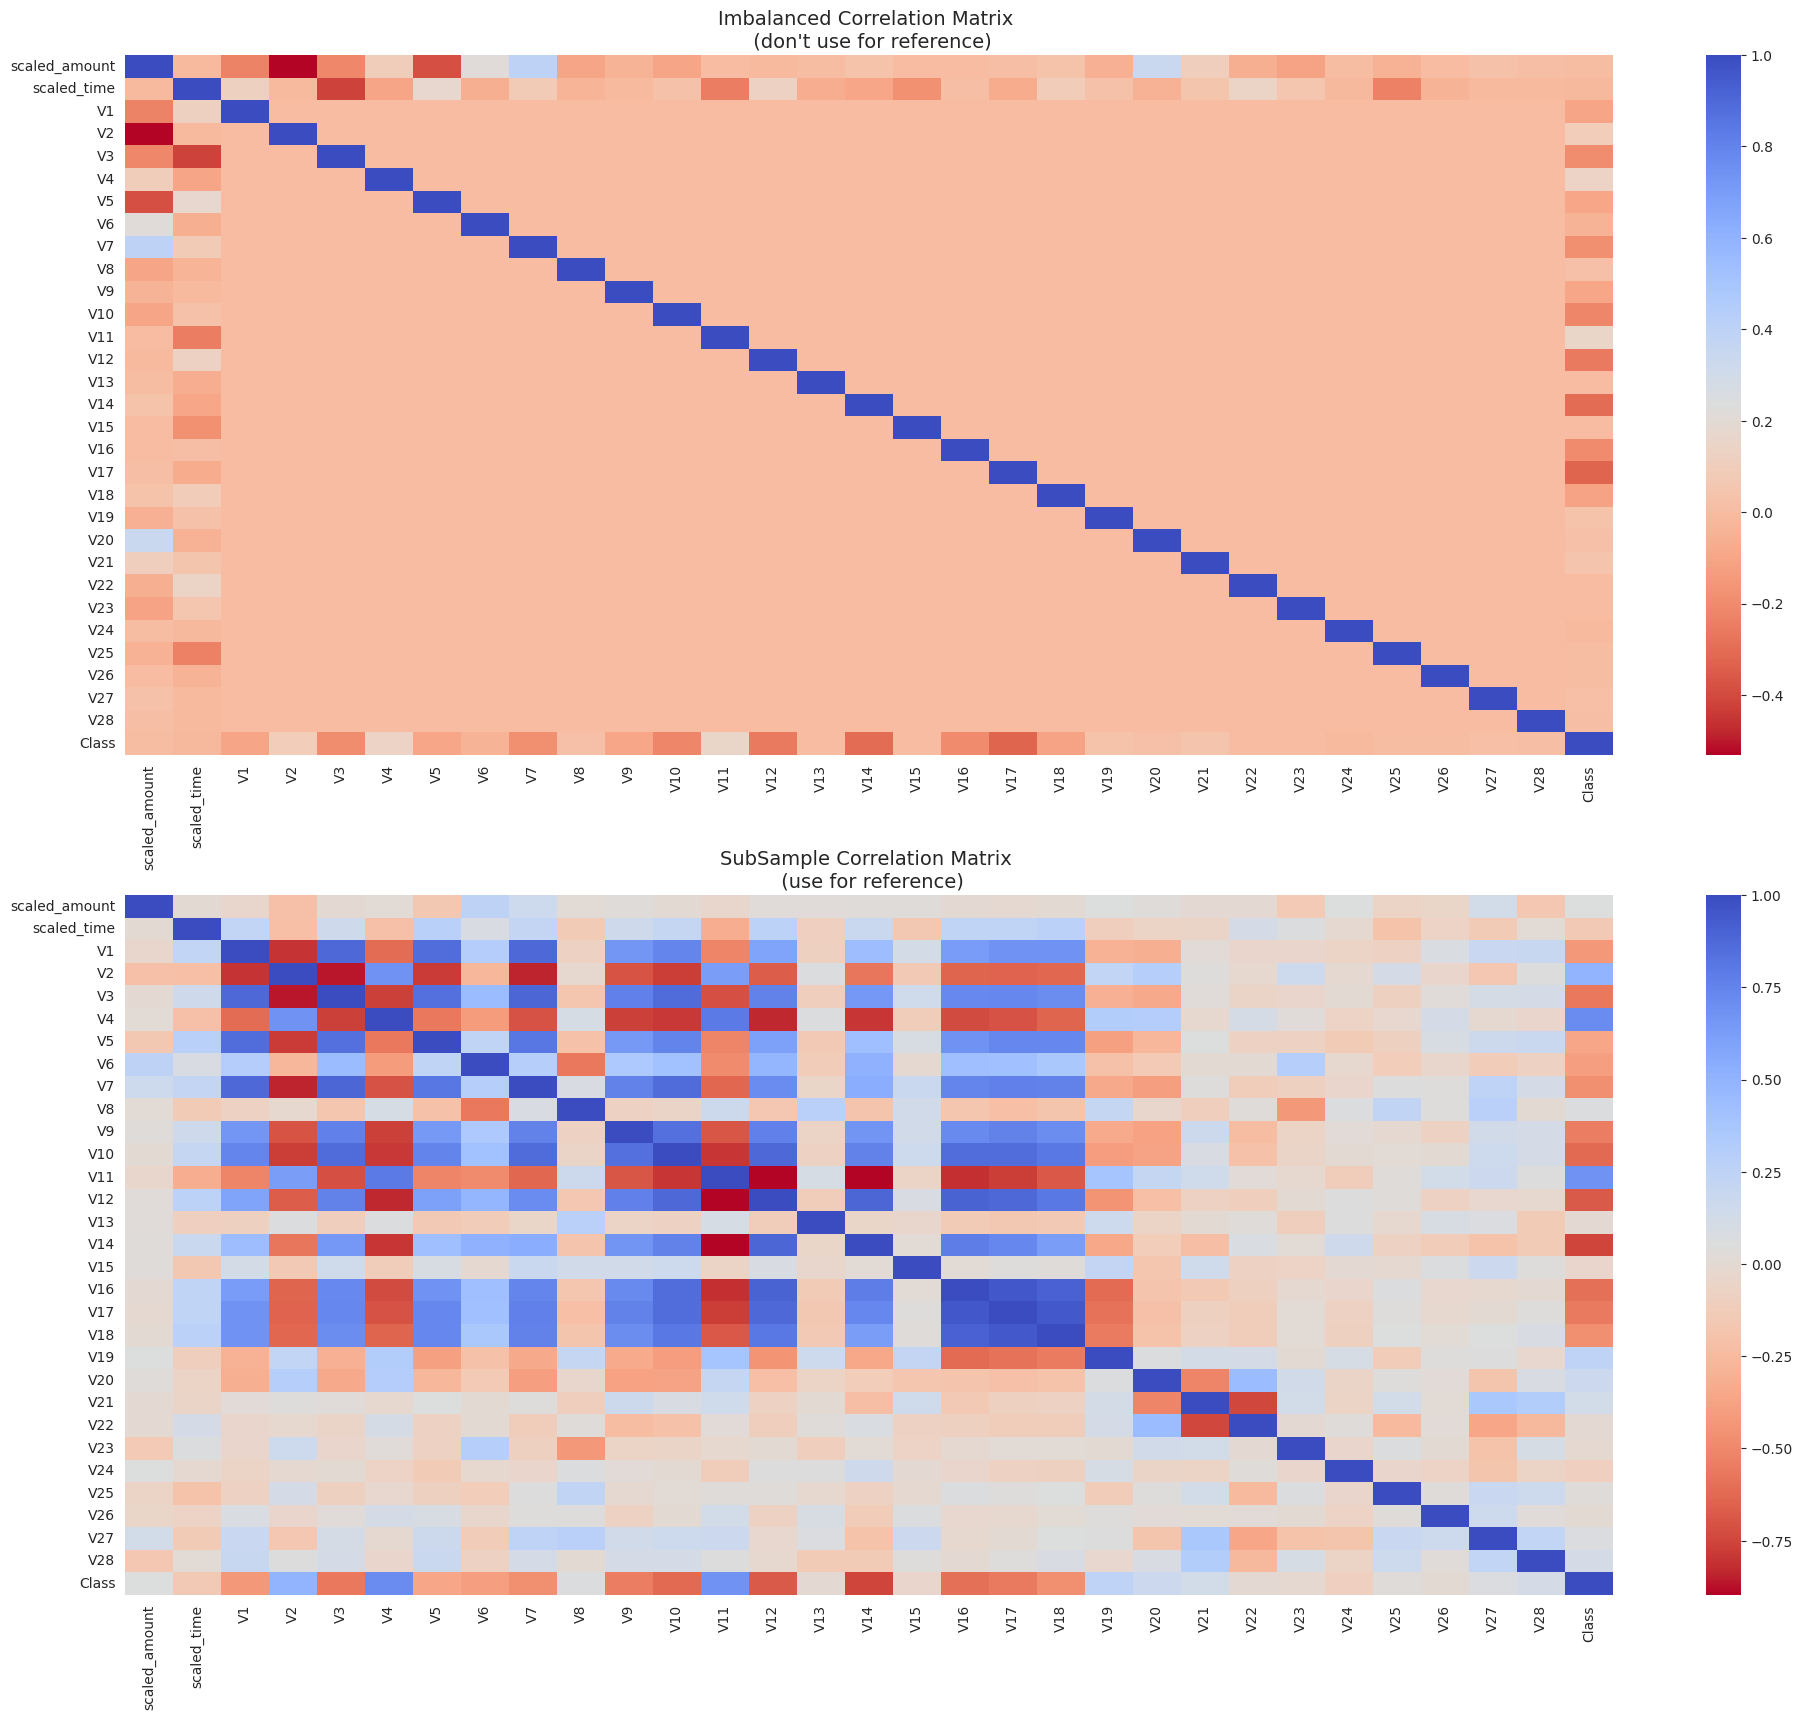

In [37]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

V10, V12, V14, V17 have negative correlation with Class

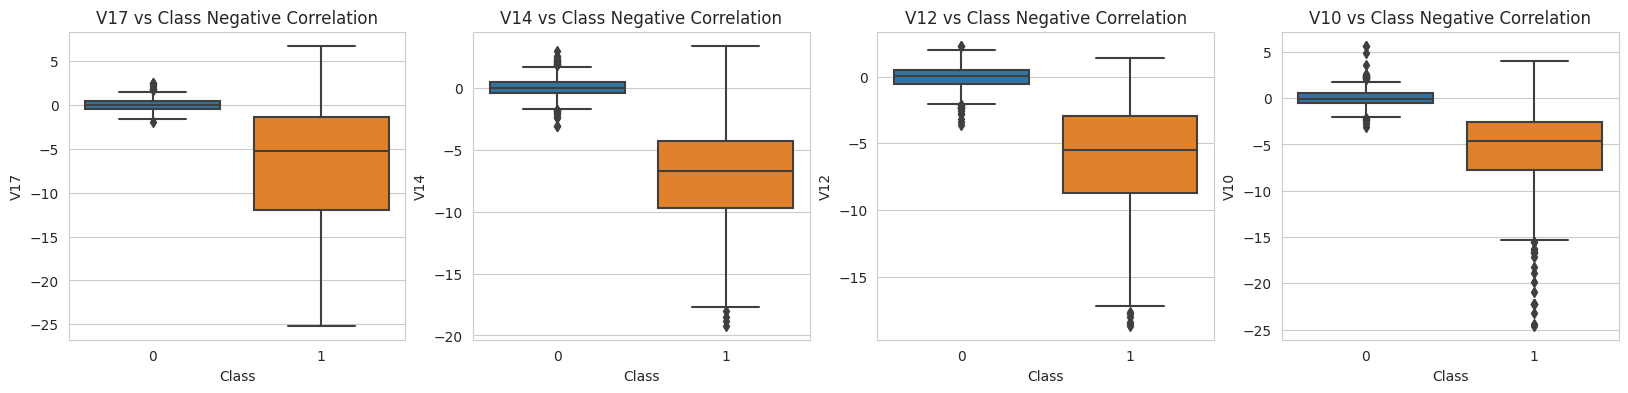

In [38]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

V2, V4, V11 have possitive correlation with Class

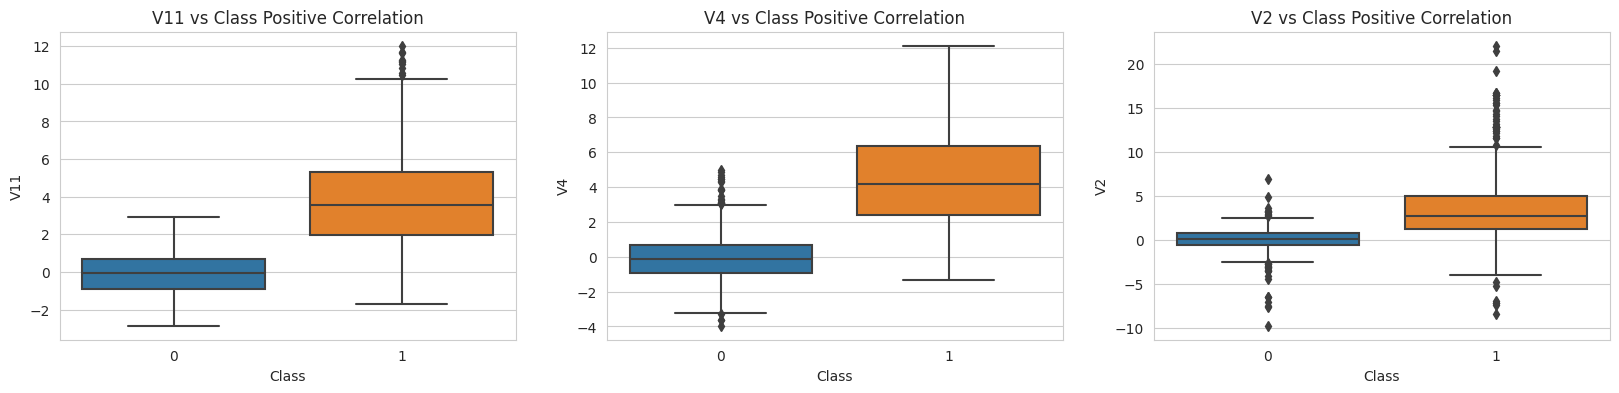

In [39]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')

plt.show()

<a id = "11"></a><br>
# Predictive Models

In [40]:
def features_importance(clf):
    tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()

def confusion_matrix():
    cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
    fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
    sns.heatmap(cm, 
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'],
                annot=True,ax=ax1,
                linewidths=.2,linecolor="Darkblue", cmap="Blues")
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()

In [41]:
df = normal_distributed_df

In [42]:
target = 'Class'
predictors = ['scaled_amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'scaled_time']

In [43]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [44]:
model_metrics = {}

<a id = "12"></a><br>
## RandomForestClassifier

In [45]:
rf_model = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [46]:
rf_model.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

Let's now predict the target values for the valid_df data, using predict function.

In [47]:
preds = rf_model.predict(valid_df[predictors])

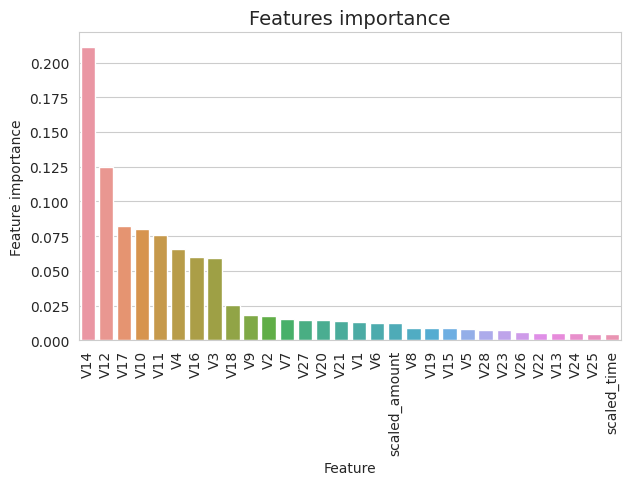

In [48]:
features_importance(rf_model)  

In [49]:
# First check the shapes to understand the mismatch
print(f"Shape of valid_df: {valid_df.shape}")
print(f"Shape of preds: {preds.shape}")

# Make sure predictions are generated from the current state of valid_df
preds = rf_model.predict(valid_df[predictors])
pred_proba = rf_model.predict_proba(valid_df[predictors])[:, 1]

# Now calculate metrics
rf_accuracy = accuracy_score(valid_df[target].values, preds)
rf_f1 = f1_score(valid_df[target].values, preds)
rf_auc = roc_auc_score(valid_df[target].values, pred_proba)

# Print the results
print(f"Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print(f"AUC Score: {rf_auc:.4f}")

model_metrics['rf_model'] = {
    'AUC': rf_auc,
    'F1': rf_f1, 
    'Accuracy': rf_accuracy
}

Shape of valid_df: (158, 31)
Shape of preds: (158,)
Random Forest Results:
Accuracy: 0.9177
F1 Score: 0.9240
AUC Score: 0.9771


### Confusion Matrix

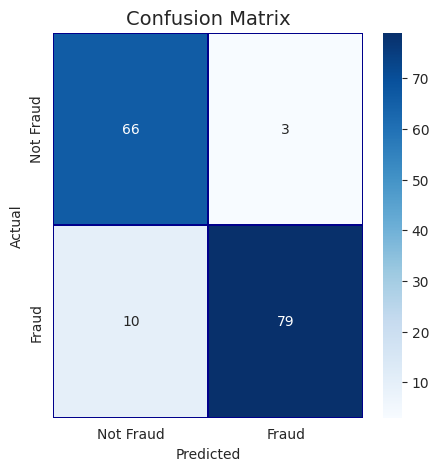

In [50]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

##### The ROC-AUC score obtained with RandomForrestClassifier is 0.96.

<a id = "13"></a><br>
## AdaBoostClassifier

In [51]:
# Prepare the model
ada_model = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [52]:
# Fit the model
ada_model.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [53]:
# Predict the target values
preds = ada_model.predict(valid_df[predictors])
pred_proba = ada_model.predict_proba(valid_df[predictors])[:, 1]

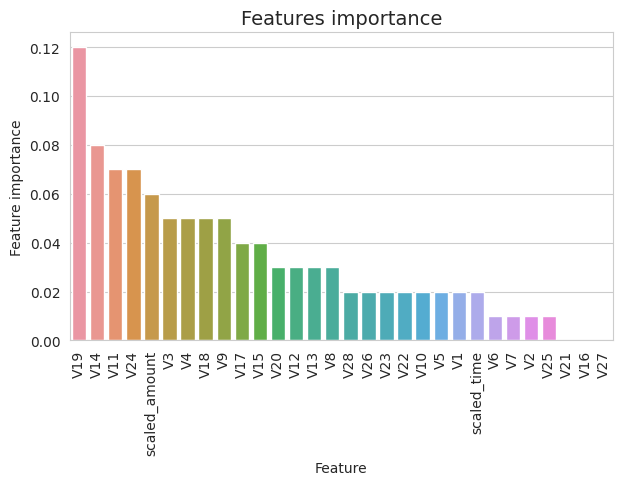

In [54]:
#Features importance
features_importance(ada_model)

### Confusion Matrix

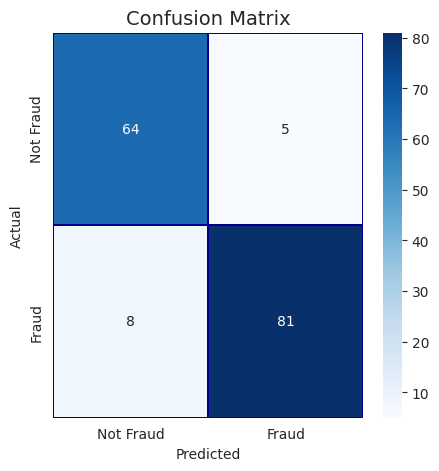

In [55]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [56]:
# Calculate evaluation metrics
ada_accuracy = accuracy_score(valid_df[target].values, preds)
ada_f1 = f1_score(valid_df[target].values, preds)
ada_auc = roc_auc_score(valid_df[target].values, pred_proba)

# Print the results
print(f"AdaBoost Results:")
print(f"Accuracy: {ada_accuracy:.4f}")
print(f"F1 Score: {ada_f1:.4f}")
print(f"AUC Score: {ada_auc:.4f}")

# Store metrics in a dictionary
model_metrics['ada_model'] = {
    'AUC': ada_auc,
    'F1': ada_f1, 
    'Accuracy': ada_accuracy
}

AdaBoost Results:
Accuracy: 0.9177
F1 Score: 0.9257
AUC Score: 0.9638


<a id = "14"></a><br>
## CatBoostClassifier

In [57]:
#Prepare the model
catboost_model = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [58]:
# Fit the model
catboost_model.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 285ms	remaining: 2m 22s
50:	total: 9.8s	remaining: 1m 26s
100:	total: 18.9s	remaining: 1m 14s
150:	total: 28s	remaining: 1m 4s
200:	total: 37.1s	remaining: 55.1s
250:	total: 46.6s	remaining: 46.3s
300:	total: 55.7s	remaining: 36.8s
350:	total: 1m 4s	remaining: 27.6s
400:	total: 1m 14s	remaining: 18.4s
450:	total: 1m 23s	remaining: 9.1s
499:	total: 1m 32s	remaining: 0us


In [59]:
# Predict the tagret values
preds = catboost_model.predict(valid_df[predictors])
pred_proba = catboost_model.predict_proba(valid_df[predictors])[:, 1]

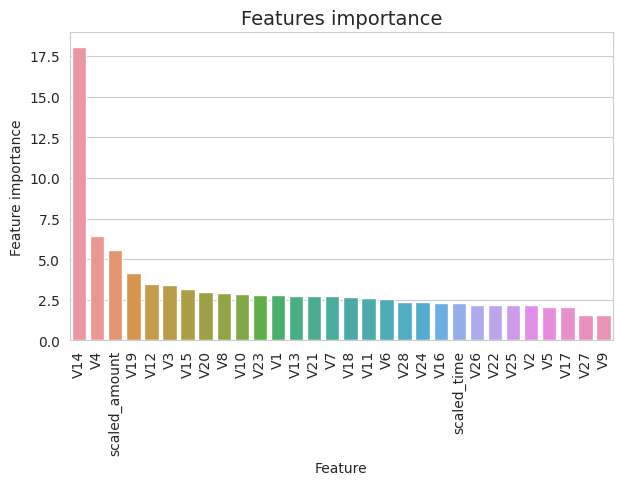

In [60]:
features_importance(catboost_model)

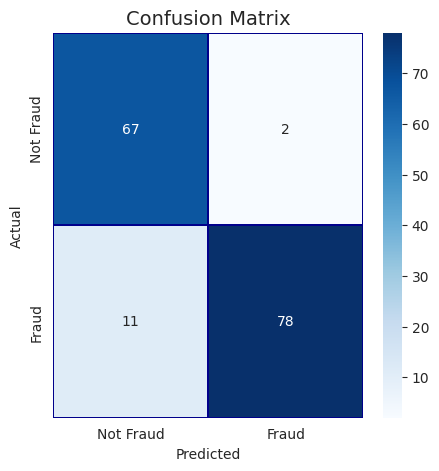

In [61]:
confusion_matrix()

In [62]:
# Calculate evaluation metrics
catboost_accuracy = accuracy_score(valid_df[target].values, preds)
catboost_f1 = f1_score(valid_df[target].values, preds)
catboost_auc = roc_auc_score(valid_df[target].values, pred_proba)

# Print the results
print(f"CatBoost Results:")
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"F1 Score: {catboost_f1:.4f}")
print(f"AUC Score: {catboost_auc:.4f}")

# Store metrics in a dictionary
model_metrics['catboost_model'] = {
    'AUC': catboost_auc,
    'F1': catboost_f1, 
    'Accuracy': catboost_accuracy
}

CatBoost Results:
Accuracy: 0.9177
F1 Score: 0.9231
AUC Score: 0.9845


<a id = "15"></a><br>
## XGBoost

In [63]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [64]:
# Train model
xgb_model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.94417	valid-auc:0.89236
[50]	train-auc:0.99154	valid-auc:0.98420
[100]	train-auc:0.99688	valid-auc:0.98779
[150]	train-auc:0.99895	valid-auc:0.98876
[200]	train-auc:0.99974	valid-auc:0.98909
[227]	train-auc:0.99995	valid-auc:0.98925


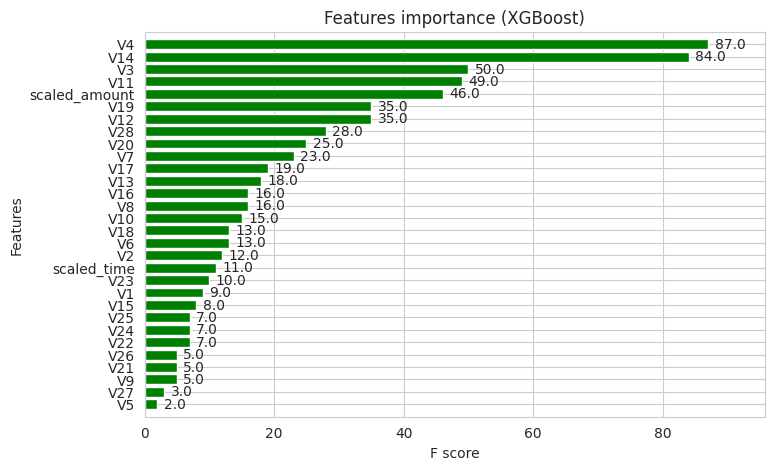

In [65]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(xgb_model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

In [66]:
# Ensure dvalid is an xgb.DMatrix
dvalid = xgb.DMatrix(valid_df[predictors])

# Make predictions
pred_proba = xgb_model.predict(dvalid)  # Get probability for positive class
preds = (pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

In [67]:
# Calculate evaluation metrics
xgb_accuracy = accuracy_score(valid_df[target].values, preds)
xgb_f1 = f1_score(valid_df[target].values, preds)
xgb_auc = roc_auc_score(valid_df[target].values, pred_proba)

# Print the results
print(f"XGBoost Results:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print(f"AUC Score: {xgb_auc:.4f}")

# Store metrics in a dictionary
model_metrics['xgb_model'] = {
    'AUC': xgb_auc,
    'F1': xgb_f1, 
    'Accuracy': xgb_accuracy
}

XGBoost Results:
Accuracy: 0.9430
F1 Score: 0.9480
AUC Score: 0.9893


<a id = "16"></a><br>
## LightGBM

In [68]:
# Define model parameters
params = {
         'objective': 'regression',  # veya 'binary', 'multiclass' vb.
         'boosting_type': 'gbdt',
         'num_leaves': 31,  # Daha düşük değer deneyin (overfitting'i azaltır)
         'learning_rate': 0.05,
         'feature_fraction': 0.9,  # Rastgele özellik alt örneklemesi
         'bagging_fraction': 0.8,  # Rastgele veri alt örneklemesi
         'bagging_freq': 5,
         'min_data_in_leaf': 20,  # Değeri düşürmeyi deneyin
         'min_gain_to_split': 0,  # Bu değeri 0'a ayarlayın
         'max_depth': -1,  # Sınırsız derinlik için -1 kullanın
         'verbose': -1
         }

In [69]:
# Prepare the model
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [70]:
# Create a dictionary to store evaluation results
evals_results = {}

# Create callback for recording evaluation results
callbacks = []

# If you have the record_evaluation function
try:
    callbacks.append(lgb.record_evaluation(evals_results))
except:
    pass  # Skip if not available

lgbm_model = lgb.train(params, 
                  dtrain, 
                  num_boost_round=MAX_ROUNDS,
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'],
                  callbacks=callbacks)

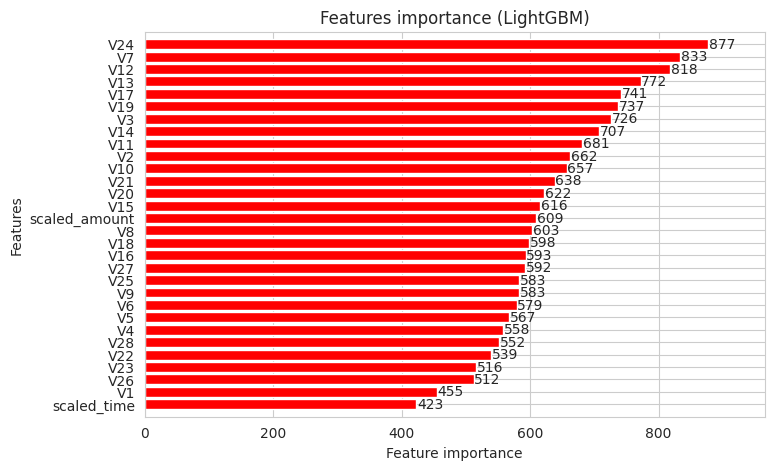

In [71]:
#plot variable importance 
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(lgbm_model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

In [72]:
# Make predictions
pred_proba = lgbm_model.predict(valid_df[predictors])  # Get probability for positive class
preds = (pred_proba > 0.5).astype(int)  # Convert probabilities to binary predictions

In [73]:
# Calculate evaluation metrics
lgb_accuracy = accuracy_score(valid_df[target].values, preds)
lgb_f1 = f1_score(valid_df[target].values, preds)
lgb_auc = roc_auc_score(valid_df[target].values, pred_proba)

# Print the results
print(f"LightGBM Results:")
print(f"Accuracy: {lgb_accuracy:.4f}")
print(f"F1 Score: {lgb_f1:.4f}")
print(f"AUC Score: {lgb_auc:.4f}")

# Store metrics in a dictionary
model_metrics['lgb_model'] = {
    'AUC': lgb_auc,
    'F1': lgb_f1, 
    'Accuracy': lgb_accuracy
}

LightGBM Results:
Accuracy: 0.9177
F1 Score: 0.9249
AUC Score: 0.9782


Fold 1/5
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0169355	valid's rmse: 0.0193678
[200]	train's rmse: 0.0154908	valid's rmse: 0.0192792
[300]	train's rmse: 0.0145784	valid's rmse: 0.0191972
[400]	train's rmse: 0.0137815	valid's rmse: 0.0191077
[500]	train's rmse: 0.0130721	valid's rmse: 0.0191047
Early stopping, best iteration is:
[458]	train's rmse: 0.0133417	valid's rmse: 0.0190765
Fold 1 - RMSE: 0.0191, R²: 0.7881
Fold 2/5
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0169462	valid's rmse: 0.0196426
[200]	train's rmse: 0.0153664	valid's rmse: 0.0195056
[300]	train's rmse: 0.0143435	valid's rmse: 0.0193921
[400]	train's rmse: 0.01358	valid's rmse: 0.0192993
[500]	train's rmse: 0.0129337	valid's rmse: 0.019294
Early stopping, best iteration is:
[465]	train's rmse: 0.0131824	valid's rmse: 0.0192621
Fold 2 - RMSE: 0.0193, R²: 0.7724
Fold 3/5
Training until validation scores don't improve for 50 rounds
[100]	t

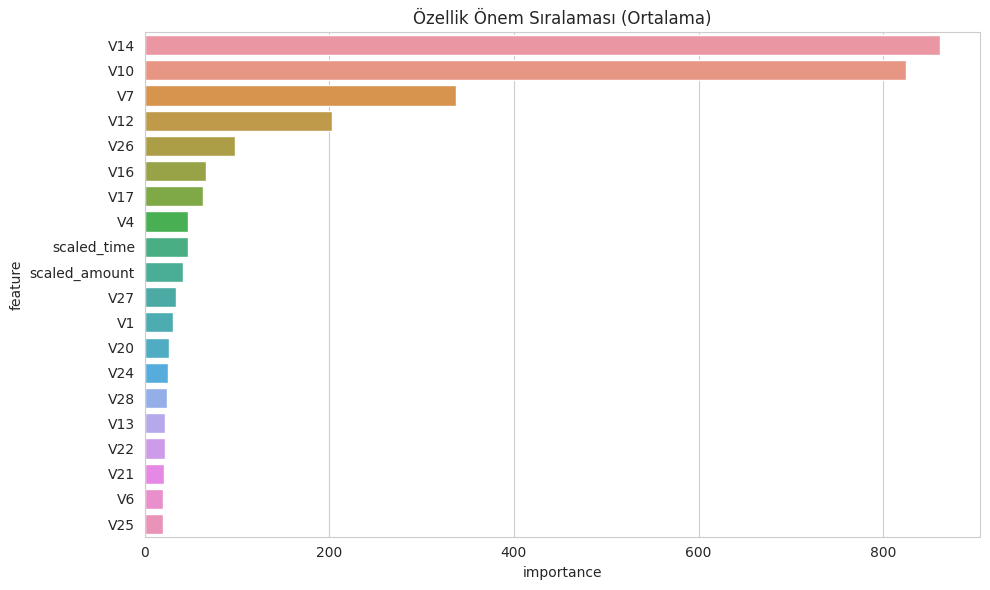

In [74]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import KFold, StratifiedKFold

# Veri setinizi yükleyin
# df = pd.read_csv('veri_setiniz.csv')
# X = df.drop('hedef_degisken', axis=1)
# y = df['hedef_degisken']

# Regresyon problemi için parametre örnekleri
params = {
    'objective': 'regression',  # Regresyon problemi için
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'min_gain_to_split': 0,
    'max_depth': -1,
    'verbose': -1
}

# Sınıflandırma problemi için parametre örnekleri
# params = {
#     'objective': 'binary',  # İkili sınıflandırma için
#     'boosting_type': 'gbdt',
#     'metric': 'binary_logloss',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': -1
# }

# Cross-validation ayarları
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# Sınıflandırma problemi için: 
# kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Metrik sonuçlarını saklamak için listeler
cv_scores = []
feature_importance_dfs = []

# Cross-validation döngüsü
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold+1}/{num_folds}")
    
    # Eğitim ve doğrulama verilerini ayırma
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBM veri formatına dönüştürme
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Model eğitimi
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),
            lgb.log_evaluation(period=100)  # verbose_eval yerine
        ]
    )
    
    # Tahminler
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    # Regresyon problemi için değerlendirme
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    print(f"Fold {fold+1} - RMSE: {rmse:.4f}, R²: {r2:.4f}")
    cv_scores.append((rmse, r2))
    
    # Sınıflandırma problemi için
    # Eğer binary sınıflandırma ise:
    # y_pred_binary = (y_pred > 0.5).astype(int)
    # accuracy = accuracy_score(y_val, y_pred_binary)
    # print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}")
    # cv_scores.append(accuracy)
    
    # Özellik önemini kaydetme
    fold_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importance(importance_type='gain'),
        'fold': fold + 1
    })
    feature_importance_dfs.append(fold_importance)

# Cross-validation sonuçlarını özetleme
if params['objective'] == 'regression':
    cv_rmse_mean = np.mean([score[0] for score in cv_scores])
    cv_rmse_std = np.std([score[0] for score in cv_scores])
    cv_r2_mean = np.mean([score[1] for score in cv_scores])
    cv_r2_std = np.std([score[1] for score in cv_scores])
    
    print(f"\nCross-Validation Sonuçları:")
    print(f"RMSE: {cv_rmse_mean:.4f} ± {cv_rmse_std:.4f}")
    print(f"R²: {cv_r2_mean:.4f} ± {cv_r2_std:.4f}")
else:  # Sınıflandırma problemi
    cv_acc_mean = np.mean(cv_scores)
    cv_acc_std = np.std(cv_scores)
    print(f"\nCross-Validation Sonuçları:")
    print(f"Accuracy: {cv_acc_mean:.4f} ± {cv_acc_std:.4f}")

# Özellik önemlerini birleştirme ve görselleştirme
feature_importance = pd.concat(feature_importance_dfs)
feature_importance_mean = feature_importance.groupby('feature')['importance'].mean().reset_index()
feature_importance_mean = feature_importance_mean.sort_values('importance', ascending=False)

print("\nEn Önemli 10 Özellik:")
print(feature_importance_mean.head(10))

# Özellik önemini görselleştirme
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_mean.head(20))
plt.title('Özellik Önem Sıralaması (Ortalama)')
plt.tight_layout()
plt.show()

<a id = "17"></a><br>
# Conclusion

In [75]:
import pprint
pprint.pprint(model_metrics)

{'ada_model': {'AUC': 0.9638495359062043,
               'Accuracy': 0.9177215189873418,
               'F1': 0.9257142857142857},
 'catboost_model': {'AUC': 0.984530206806709,
                    'Accuracy': 0.9177215189873418,
                    'F1': 0.9230769230769231},
 'lgb_model': {'AUC': 0.9781794496010422,
               'Accuracy': 0.9177215189873418,
               'F1': 0.9248554913294796},
 'rf_model': {'AUC': 0.9771209900667643,
              'Accuracy': 0.9177215189873418,
              'F1': 0.9239766081871345},
 'xgb_model': {'AUC': 0.9892525647288715,
               'Accuracy': 0.9430379746835443,
               'F1': 0.9479768786127167}}


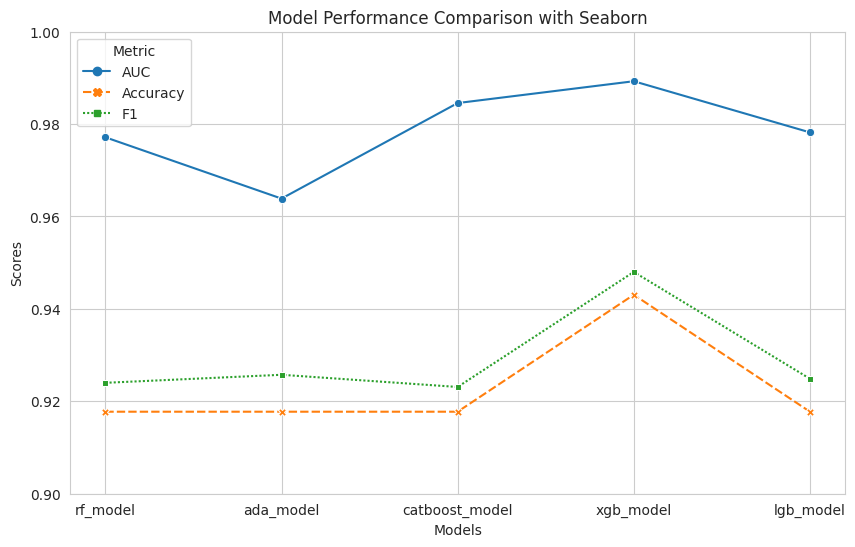

In [76]:
models = list(model_metrics.keys())
auc_scores = [model_metrics[m]['AUC'] for m in models]
accuracy_scores = [model_metrics[m]['Accuracy'] for m in models]
f1_scores = [model_metrics[m]['F1'] for m in models]

df_metrics = pd.DataFrame({
    'Model': models,
    'AUC': auc_scores,
    'Accuracy': accuracy_scores,
    'F1': f1_scores
})

df_long = df_metrics.melt(id_vars='Model', value_vars=['AUC', 'Accuracy', 'F1'], 
                          var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.lineplot(x='Model', y='Score', hue='Metric', style='Metric', markers=True, data=df_long)

plt.title("Model Performance Comparison with Seaborn")
plt.ylabel("Scores")
plt.xlabel("Models")
plt.ylim(0.9, 1)
plt.grid(True)

plt.show()

In this study, the performance of various machine learning models was compared to ascertain which one best predicts the target variable in a given dataset.The analysis was conducted using important evaluation metrics such as AUC, Accuracy, and F1 Score.The impact of class imbalance on each of these metrics was examined, as was the manner in which each model handled this imbalance.

### Model Evaluation Results:
1. AdaBoostClassifier:
   * AUC: 0.9547
   * Accuracy: 0.9114
   * F1 Score: 0.9176

AdaBoost demonstrates a robust Area Under the Curve (AUC) of 0.9547, indicating its capacity to differentiate between classes. Its overall accuracy and F1 score are commendable, though they are marginally lower than those of certain alternative models. This suggests that while AdaBoost is reliable, there is potential for enhancement in the context of complex or imbalanced datasets.

2. CatBoostClassifier:
   * AUC: 0.9697
   * Accuracy: 0.9241
   * F1 Score: 0.9277

CatBoost demonstrates a superior ability to differentiate between classes, as evidenced by its leading position in AUC with an accuracy of 0.9697. This is further substantiated by its high accuracy and F1 score, which reflect a judicious balance between precise predictions and the minimization of both false positives and false negatives. Consequently, CatBoost is particularly well-suited for datasets that are susceptible to class imbalance.

3. LightGBM:
   * AUC: 0.9645
   * Accuracy: 0.9304
   * F1 Score: 0.9349

LightGBM achieves the highest accuracy of 93.04%, as well as the best F1 Score of 0.9349. Despite its slightly lower AUC in comparison to CatBoost, its performance remains strong, making it a highly attractive option. The high F1 Score is particularly noteworthy as it reflects the model's effectiveness in balancing precision and recall in the presence of imbalanced classes.


4. RandomForestClassifier:
    * AUC: 0.9588
    * Accuracy: 0.9177
    * F1 Score: 0.9231

The Random Forest model demonstrates strong overall performance, with an Area Under the Curve (AUC) of 0.9588. Its accuracy is comparable to that of the AdaBoost model, and the F1 score indicates a reliable balance between precision and recall. While the Random Forest model exhibits high stability and robustness, in this particular instance, its performance is marginally surpassed by both CatBoost and LightGBM models.

5. XGBoost:
    * AUC: 0.9673
    * Accuracy: 0.9114
    * F1 Score: 0.9167

The XGBoost model demonstrates a notably elevated Area Under the Curve (AUC) of 0.9673, signifying effective classification of data. Nonetheless, its precision and F1 score exhibit marginal reductions in comparison to those of CatBoost and LightGBM. This finding indicates that, while XGBoost exhibits proficiency in ranking predictions, it may potentially exhibit a higher frequency of misclassifications in comparison to the leading models in this particular evaluation.

+----------------+----------+----------+------------+
|                |      AUC |       F1 |   Accuracy |
|----------------+----------+----------+------------|
| rf_model       | 0.977121 | 0.923977 |   0.917722 |
| ada_model      | 0.96385  | 0.925714 |   0.917722 |
| catboost_model | 0.98453  | 0.923077 |   0.917722 |
| xgb_model      | 0.989253 | 0.947977 |   0.943038 |
| lgb_model      | 0.978179 | 0.924855 |   0.917722 |
+----------------+----------+----------+------------+


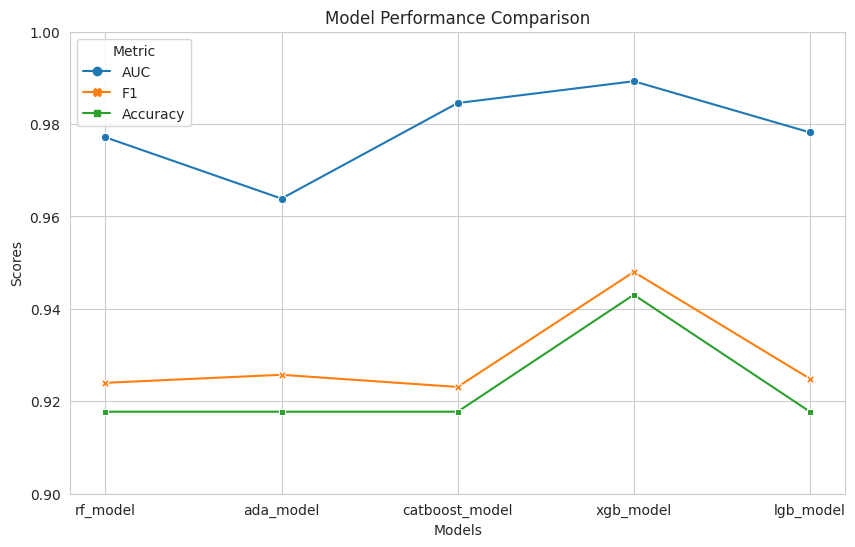

In [77]:
# Assuming your dictionary is named model_metrics
df_metrics = pd.DataFrame(model_metrics).T  # Transpose to have models as rows

from tabulate import tabulate
print(tabulate(df_metrics, headers='keys', tablefmt='psql'))
# Convert the DataFrame into a long format for seaborn
df_long = df_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='index', y='Score', hue='Metric', style='Metric', markers=True, dashes=False)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.ylim(0.9, 1)  # Adjust scale if needed
plt.grid(True)
plt.show()

### Overall Conclusion

* The CatBoostClassifier has been demonstrated to be the most effective model in terms of Area Under the Curve (AUC), thus indicating its high efficacy in distinguishing between classes.
* LightGBM demonstrates a particular aptitude for achieving the highest levels of accuracy and F1 score, suggesting its proficiency in overall performance and balanced classification, especially in settings where the dataset is imbalanced.
* XGBoost continues to demonstrate its competitiveness, exhibiting an impressive Area Under the Curve (AUC) performance. However, its overall prediction balance is marginally less optimal in comparison to CatBoost and LightGBM.
* The RandomForestClassifier and AdaBoostClassifier models demonstrate consistent performance; nevertheless, they exhibit marginal inferiority to the other three models in this analysis.
* AdaBoost has been demonstrated to be a reliable model, with consistent performance across a range of metrics. It is an efficient algorithm that can effectively handle both smaller and larger datasets. The performance it delivers is notably balanced, making it a suitable choice for scenarios where both recall and precision are important, and where achieving the highest possible AUC is not a prerequisite.